This notebook deliver insights and predictions for spaceship accident. Main aim is to predict passengers who were transported to alternate destination. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score

In [2]:
train =pd.read_csv('E:/competations/spaceship_kaggle/train.csv')
test=pd.read_csv('E:/competations/spaceship_kaggle/test.csv')
#submission=pd.read_csv('E:/competations/spaceship_kaggle/submission.csv')
list=[train, test]
data=pd.concat(list, axis=0)
data_copy=data.copy()

In [4]:
#check percentage of misssing values 
(data.isna().sum()/data.shape[0])*100

PassengerId      0.000000
HomePlanet       2.220509
CryoSleep        2.390131
Cabin            2.305320
Destination      2.112567
Age              2.081727
VIP              2.282190
RoomService      2.027756
FoodCourt        2.228219
ShoppingMall     2.359291
Spa              2.189668
VRDeck           2.066307
Name             2.266769
Transported     32.976099
dtype: float64

In [5]:
#Replace missing values 
data.HomePlanet.fillna(data.HomePlanet.mode()[0], inplace=True)
data.Cabin.fillna('OtheR',inplace=True)
data['CryoSleep'].fillna(data.CryoSleep.mode()[0], inplace=True)
data.Age.fillna(data.Age.median(), inplace=True)
data.VIP.fillna(data.VIP.mode()[0], inplace=True)
data.Destination.fillna(data.Destination.mode()[0], inplace=True)
data.RoomService.fillna(0, inplace=True)
data.FoodCourt.fillna(0, inplace=True)
data.ShoppingMall.fillna(0,inplace=True)
data.Spa.fillna(0, inplace=True)
data.VRDeck.fillna(0,inplace=True)

In [6]:
data.HomePlanet.value_counts()

Earth     7153
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

FEATURE ENGINEERING
1. new_cabin
This variable was derived from cabin column, it gives information on sitting position of passenger. S represents starboard(Right side of the ship), P=port(left side of the ship), while R=other(all missing values were given this label).
2. pass_grp_size
This feature was derived from passengerId, the first four digits in passengerId string represent the group a passenger was travelling with, therefore frequency of this string is equal to the number of group members/ group size. We will see if this is important when we get to data analysis and modeling.
3. Age group 
This was generated by binning the age column. 
4. P_class
This variable is based on whether a passenger ordered vip service or not. My assumption is if passenger ordered any vip service they were traveling in first class. 
5. Luxury_spending
This is the total of RoomService, FoodCourt, ShoppingMall, Spa, VRDeck columns.
6. Deck_number
This was derived from cabin, the first letter in cabin identifier. This takes letters A-G and O for other(this is for missing values)

In [7]:
for i in data.Cabin:
    data['new_cabin']=data.Cabin.apply(lambda i: i[-1])

#create age groups from age variable 
bins=[-1,4,9,17,30,45,60,79]
labels=['Baby','Child','Teen','Young_adult', 'Middle_adult','Old_adult','Senior_citizen']
data['New_age']=pd.cut(data.Age, bins=bins, labels=labels)

#create new variable luxury_spending       
data['Luxury_spending']=data.RoomService + data.FoodCourt +data.Spa +data.ShoppingMall + data.VRDeck
#create passenger group size from passengerId column. 

##deck column
for i in data.Cabin:
    data['Deck']=data.Cabin.apply(lambda i: i[0])
#introduce travel group size label colum
#for i in data.PassengerId:
    #data.pass_grp_label=data.PassengerId.apply(lambda i: i[0:4])

In [44]:
print(data.head())

  PassengerId HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa      False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth      False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa      False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa      False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth      False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

  Transported new_cabin       New_age  Luxury_spending Deck  
0       False         P  Middle_adul

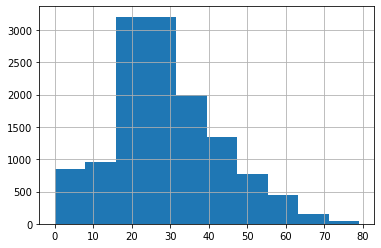

In [45]:
data.Age.hist()
plt.show()

After data preprocessing and feature engineering let's separate data into train and test. Exploratory analysis I used new train set. 

In [81]:
new_train=data[:8693]
new_test=data[8694:]

In [9]:
new_train.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Is there's a relationship between seat postion(right-side, left-side or anywhere in the ship) 
and being transported to alternative destination in case accident occur?
Chi-square test of indipendence can clear doubts if indeed there is relationship between these two.
Hypothesis:
H0: Seat position and being transported to alt destination are indipendent.
H1: Seat position and being transported to alt destination are dependent.
    
The p-value is too small , so we reject null hypothesis and conclude there is a significant relationship/dependence between seat position and being transported to alternative destination if the event(accident) occur.

S=startboard(the Right side of a ship viewing from front)
P=Port(left side of a ship viewing from front)
R=Other(anywhere else in the boat, made-up this category to replace missing values)
See graph below


In [10]:
new_cabin=pd.crosstab(new_train.new_cabin, new_train.Transported)
new_cabin.index=['P','S','R']
new_cabin.columns=['False','True']
stats.chi2_contingency(observed=new_cabin)

(91.47519343432869,
 1.3690336728997533e-20,
 2,
 array([[2087.75911653, 2118.24088347],
        [  98.77890257,  100.22109743],
        [2128.4619809 , 2159.5380191 ]]))

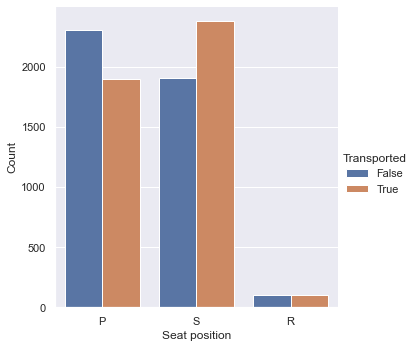

In [11]:
sns.set_theme(style='darkgrid')
sns.catplot(x='new_cabin',hue='Transported', kind='count', data=new_train)
plt.xlabel('Seat position')
plt.ylabel('Count')
plt.show()

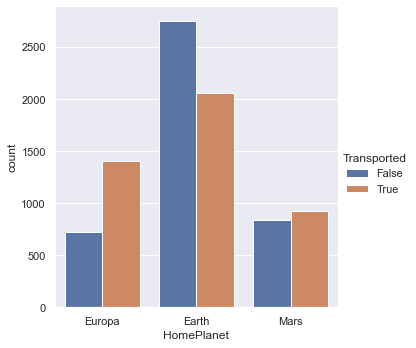

In [59]:
sns.catplot(x='HomePlanet',hue='Transported', kind='count', data=new_train)
plt.show()

Passengers from Europa and Mars have high chance being transported to alternate direction compared to their counterparts from earth. Interesting observation, this variable will be useful in modeling. is there any dependence between these to variables? checking indipendence between the two can be helpful. There is, check chi-square output below.

In [12]:
home=pd.crosstab(new_train.HomePlanet, new_train.Transported, margins=True)
home.index=['Earth','Europa','Mars','col_total']
home.columns=['False', 'True','row_total']
observed=home.iloc[0:3,0:2]
stats.chi2_contingency(observed=observed)

(318.93444995471856,
 5.549631517016864e-70,
 2,
 array([[2384.09582423, 2418.90417577],
        [1057.77809732, 1073.22190268],
        [ 873.12607845,  885.87392155]]))

In [53]:
home

,False,True,row_total
Earth,2749,2054,4803
Europa,727,1404,2131
Mars,839,920,1759
col_total,4315,4378,8693


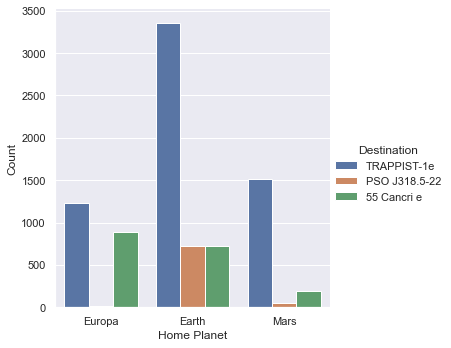

In [60]:
sns.catplot(x='HomePlanet',hue='Destination', kind='count',data=new_train)
plt.xlabel('Home Planet')
plt.ylabel('Count')
plt.show()

This is out of context but important in a business scenario.
From the above graph, we see where passengers from the 3 planets are headed. What are their intersts. The largest proportion of passengers are headed to TRAPPIST-1e. Why?
passengers from europe and mars are more interested in TRAPPIST-1E and 55 Cancrie. Why? 

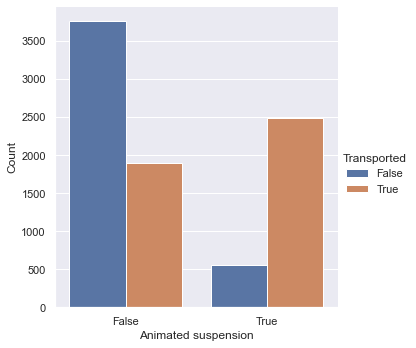

In [13]:
sns.catplot(x='CryoSleep',hue='Transported', kind='count', data=new_train)
plt.xlabel('Animated suspension')
plt.ylabel('Count')
plt.show()


Passengers in animated suspension have higher chance of being transported to alternate directions compared to their counterparts. 

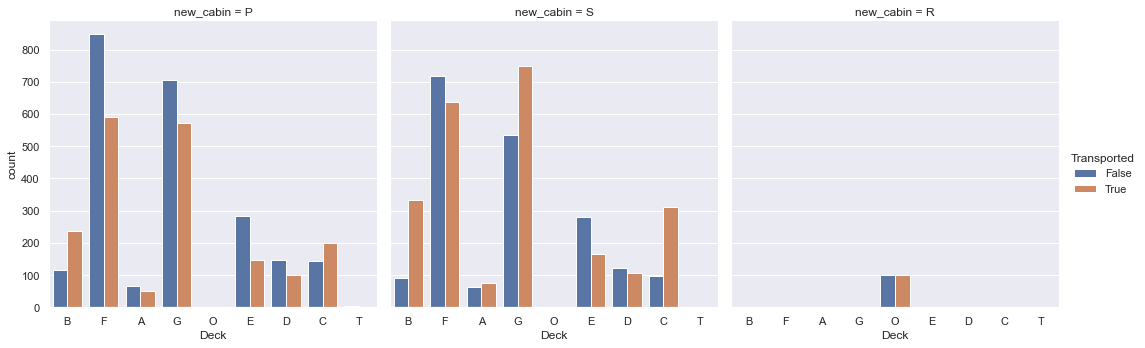

In [14]:
sns.set_theme(style='darkgrid')
sns.catplot(x='Deck',hue='Transported',col='new_cabin', kind='count', data=new_train)
#plt.xlabel('Deck label')
plt.show()


Notice something interesting from the graph above:
There is something fascinating about deck 'O' , all passengers with missing data on the ticket column are in this deck. Why? I made-up this category R to represent those with missing ticket number, interestingly they all are in deck 'O'. 

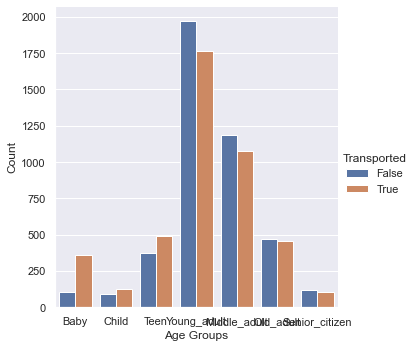

In [63]:
sns.catplot(x='New_age',hue='Transported', kind='count', data=new_train)
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.show()

In [15]:
data.Luxury_spending.describe()

count    12970.000000
mean      1433.221049
std       2807.369708
min          0.000000
25%          0.000000
50%        716.000000
75%       1442.000000
max      35987.000000
Name: Luxury_spending, dtype: float64

In [ ]:
categorise the luxury_spending column into zero_spending, Low, Average, High

In [24]:
bin1=[-1,716,1442,36000]
label=['Zero_Spenders','Low','High']
data['Spend_grps']=pd.cut(data.Luxury_spending, bins=bin1, labels=label)

In [25]:
data.Spend_grps.value_counts()

Zero_Spenders    6507
High             3242
Low              3221
Name: Spend_grps, dtype: int64

In [26]:
x_cols=['HomePlanet','CryoSleep','Destination','VIP','new_cabin','Deck']
x=data[x_cols]
y=data['Transported'].map({True:1,False:0})
x=pd.get_dummies(x)
x['CryoSleep']=data['CryoSleep'].map({False:0, True:1})
x['VIP']=data['VIP'].map({False:0,True:1})
x['Spend_grps']=data['Spend_grps'].map({'Zero_Spenders':0,'Low':1,'High':2})
x['New_age']=data['New_age'].map({'Baby':0, 'Child':1, 'Teen':2, 'Young_adult':3,'Middle_adult':4,'Old_adult':5,'Senior_citizen':6})
#x.drop('Luxury_spending', axis=1, inplace=True)

In [27]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   CryoSleep                  12970 non-null  int64   
 1   VIP                        12970 non-null  int64   
 2   HomePlanet_Earth           12970 non-null  uint8   
 3   HomePlanet_Europa          12970 non-null  uint8   
 4   HomePlanet_Mars            12970 non-null  uint8   
 5   Destination_55 Cancri e    12970 non-null  uint8   
 6   Destination_PSO J318.5-22  12970 non-null  uint8   
 7   Destination_TRAPPIST-1e    12970 non-null  uint8   
 8   new_cabin_P                12970 non-null  uint8   
 9   new_cabin_R                12970 non-null  uint8   
 10  new_cabin_S                12970 non-null  uint8   
 11  Deck_A                     12970 non-null  uint8   
 12  Deck_B                     12970 non-null  uint8   
 13  Deck_C                     12970

<AxesSubplot:>

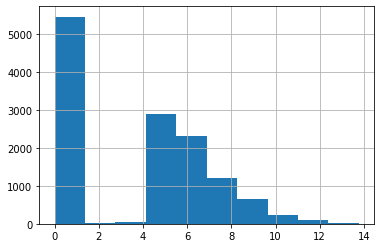

In [93]:
x.shape

(12970, 22)

In [28]:
x.isna().sum()

CryoSleep                    0
VIP                          0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
new_cabin_P                  0
new_cabin_R                  0
new_cabin_S                  0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_O                       0
Deck_T                       0
Spend_grps                   0
New_age                      0
dtype: int64

In [29]:
scaler=StandardScaler()
X=scaler.fit_transform(x)

Split the data back into train and test. This notebook focuses on knn and cross-validation as a tuning approach. 

In [30]:
x_train=X[:8693]
x_test=X[8694:]
y_train=y[:8693]
y_test=y[8694:]

(4276,)

In [63]:
def val_score(n_neighbors):
    avg=[]
    std=[]
    for i in n_neighbors:
        score=cross_val_score(KNN(n_neighbors=i),x_train,y_train, cv=7)
        avg.append(score.mean())
        std.append(score.std())
    return avg, std

In [64]:
n_neighbors=range(1,30)
avg, std=val_score(n_neighbors)

In [ ]:
avg

Using cross validation method we can find the optimal number of neighbors to choose for our model. 
The average accuracy is the mean of training accuracy of the 10 folds for each k-neighbor. 

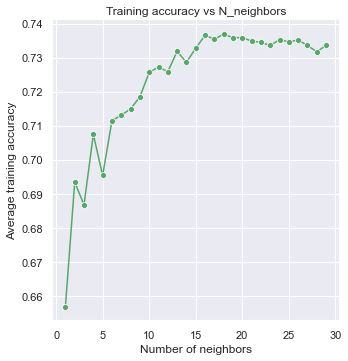

In [66]:
sns.relplot(x=n_neighbors, y=avg, kind='line',color='g', marker='o')
plt.xlabel('Number of neighbors')
plt.ylabel('Average training accuracy')
plt.title('Training accuracy vs N_neighbors')
plt.show()

The average training accuracy shows upward trajectory from k=10 and starts to decline from k=26. Accuracy is at peak at k=20 and k=26, therefore to choose optimal k there is need to check variance in the accuracy. The model is optimal when variance in training accuracy is minimal.  

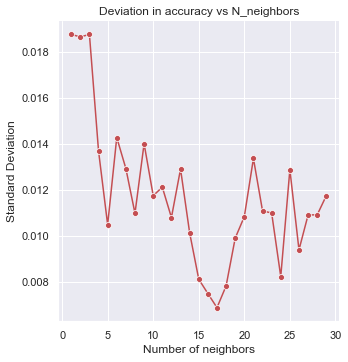

In [67]:
sns.relplot(x=n_neighbors, y=std, kind='line',color='r', marker='o')
plt.xlabel('Number of neighbors')
plt.ylabel('Standard Deviation')
plt.title('Deviation in accuracy vs N_neighbors')
plt.show()

There is minimal variance in accuracy at k=17, consequently best choice for k value is 17. This is where the model is optimal. Therefore, I trained a KNN model with 17 nearest neighbors and 7 folds cross-validation.

In [76]:
model=KNN(n_neighbors=17)
model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=17)

In [78]:
k=model.predict(x_test)

In [89]:
submission=pd.DataFrame()
submission['PassengerId']=new_test['PassengerId']
submission['Transported']=k

In [90]:
submission['Transported']=submission['Transported'].map({0.0:False, 1.0:True})
submission.head()

,PassengerId,Transported
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
5,0027_01,False


In [9]:
sub.write.csv('E:/competations/spaceship_kaggle/submission.csv', index=False)
#train.to_csv('E:/competations/spaceship_kaggle/train.csv')

AttributeError: 'DataFrame' object has no attribute 'write_csv'

In [4]:
sub=pd.read_csv('E:/competations/spaceship_kaggle/submission.csv')

In [5]:
sub['Transported']=sub['Transported'].astype(boolean)

In [6]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 20.9+ KB
